In [26]:
%matplotlib inline

In [27]:
import pandas as pd
import geopandas
import sqlite3
from shapely import wkt
import folium
from mapboxgl.viz import *
from mapboxgl.utils import *


# Must be a public token, starting with `pk`
token = 'pk.eyJ1IjoiY2Ftd2F0c29uIiwiYSI6ImNqZXNwd285bDB5cnAyd212Y3pucjN5YnQifQ.Xj3cN1bUdRebhyJJy2yunQ'

In [28]:
conn = sqlite3.connect('cap_data.db')
#query = "select * from cap_alerts"
#query = "select cap_alerts.refID, cap_alerts.identifier, cap_alerts.sender, cap_alerts.sent, cap_alerts.status, cap_alerts.msgType, cap_alerts.rev_refid, cap_info.infoID, cap_info.expires,cap_info.event,cap_info.category,cap_info.certainty,cap_info.severity,cap_info.headline,cap_info.description,cap_info.instruction,cap_poly.polygon from cap_alerts, cap_info, cap_area, cap_poly where cap_alerts.refID = cap_info.refID and cap_info.refid = cap_area.refID and cap_info.infoid = cap_area.infoID and cap_area.areaDesc = cap_poly.areaDesc and datetime(cap_info.expires) >= datetime('now') ORDER BY cap_info.expires ASC"
query = """select cap_alerts.refID,
	cap_alerts.identifier, 
	cap_alerts.sender, 
	cap_alerts.sent, 
	cap_alerts.status,
	cap_alerts.msgType,
	cap_info.infoID,    
	cap_info.expires,
	cap_info.event,
	cap_info.category,
	cap_info.responseType,
	cap_info.certainty,
	cap_info.severity,
	cap_info.urgency,
	cap_info.headline,
	cap_info.description,
	cap_info.instruction,
	cap_poly.polygon,
	cap_alerts.rev_refID
	from cap_alerts, cap_info, cap_area, cap_poly 
	where cap_alerts.refID = cap_info.refID 
	and cap_info.refid = cap_area.refID 
	and cap_info.infoid = cap_area.infoID 
	and cap_area.areaDesc = cap_poly.areaDesc
	and datetime(cap_info.expires) >= datetime('now')
	and rev_refID is NULL
	ORDER BY cap_alerts.sent DESC
"""
df = pd.read_sql_query(query,conn)


In [29]:
df.head()

,refID,identifier,sender,sent,status,msgType,infoID,expires,event,category,responseType,certainty,severity,urgency,headline,description,instruction,polygon,rev_refID
0,"cap-pac@canada.ca,urn:oid:2.49.0.1.124.2025656...",urn:oid:2.49.0.1.124.2025656316.2020,cap-pac@canada.ca,2020-07-10T19:18:48-00:00,Actual,Update,0,2020-07-10T22:09:48-00:00,thunderstorm,Met,Monitor,Likely,Moderate,Immediate,severe thunderstorm warning in effect,"\nAt 3:18 p.m. EDT, Environment Canada meteoro...","\nTake cover immediately, if threatening weath...","POLYGON ((-81.753 43.3073, -81.755 43.2931, -8...",None
1,"cap-pac@canada.ca,urn:oid:2.49.0.1.124.2025656...",urn:oid:2.49.0.1.124.2025656316.2020,cap-pac@canada.ca,2020-07-10T19:18:48-00:00,Actual,Update,0,2020-07-10T22:09:48-00:00,thunderstorm,Met,Monitor,Likely,Moderate,Immediate,severe thunderstorm warning in effect,"\nAt 3:18 p.m. EDT, Environment Canada meteoro...","\nTake cover immediately, if threatening weath...","POLYGON ((-82.4848 42.462, -82.6214 42.5101, -...",None
2,"cap-pac@canada.ca,urn:oid:2.49.0.1.124.4166603...",urn:oid:2.49.0.1.124.4166603599.2020,cap-pac@canada.ca,2020-07-10T19:14:55-00:00,Actual,Update,0,2020-07-10T22:12:55-00:00,thunderstorm,Met,Monitor,Likely,Moderate,Immediate,severe thunderstorm warning in effect,"\nAt 3:13 p.m. EDT, Environment Canada meteoro...","\nTake cover immediately, if threatening weath...","POLYGON ((-80.406 44.1938, -80.3807 44.1809, -...",None
3,"cap-pac@canada.ca,urn:oid:2.49.0.1.124.4155263...",urn:oid:2.49.0.1.124.4155263377.2020,cap-pac@canada.ca,2020-07-10T19:12:46-00:00,Actual,Update,0,2020-07-10T21:49:46-00:00,thunderstorm,Met,Monitor,Likely,Moderate,Immediate,severe thunderstorm warning in effect,"\nAt 3:11 p.m. EDT, Environment Canada meteoro...","\nTake cover immediately, if threatening weath...","POLYGON ((-79.5175 47.5701, -79.4946 47.5988, ...",None
4,"cap-pac@canada.ca,urn:oid:2.49.0.1.124.2083835...",urn:oid:2.49.0.1.124.2083835513.2020,cap-pac@canada.ca,2020-07-10T19:10:50-00:00,Actual,Update,0,2020-07-10T22:04:50-00:00,thunderstorm,Met,Monitor,Likely,Moderate,Immediate,severe thunderstorm warning in effect,"\nAt 3:09 p.m. EDT, Environment Canada meteoro...","\nTake cover immediately, if threatening weath...","POLYGON ((-82.4889 42.3476, -82.4404 42.4783, ...",None


In [30]:
# Convert WKT data in polygon column to shapely format for gdf
df['polygon'] = df['polygon'].apply(wkt.loads)
#df.head()

In [31]:
# Create GeoDataFrame
gdf = geopandas.GeoDataFrame(df, geometry='polygon')

In [32]:
# Dissolve data based on ID and info_count 
gdf = gdf.dissolve(by=['identifier', 'infoID'], aggfunc='first')

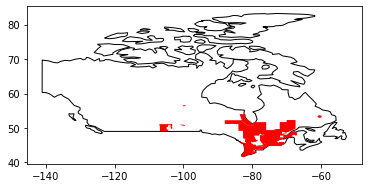

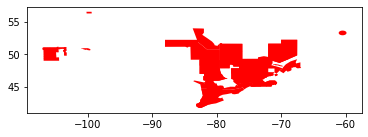

In [33]:
import matplotlib.pyplot as plt

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world[world.name == 'Canada'].plot(
    color='white', edgecolor='black')

gdf.plot(ax=ax, color='red')
gdf.plot(color='red')
plt.show()

In [34]:
gdf.count()

polygon         33
refID           33
sender          33
sent            33
status          33
msgType         33
expires         33
event           33
category        33
responseType    31
certainty       33
severity        33
urgency         33
headline        33
description     33
instruction     24
rev_refID        0
dtype: int64

In [41]:
gdf.drop('sender', axis=1)
gdf.drop('status', axis=1)
gdf.drop('msgType', axis=1)
gdf.drop('event', axis=1)
gdf.drop('category', axis=1)
gdf.drop('rev_refID', axis=1)

# Write out to GeoJson file.
gdf.to_file("cdn_alerts.geojson", driver='GeoJSON')
gdf.head()

,,polygon,refID,sender,sent,status,msgType,expires,event,category,responseType,certainty,severity,urgency,headline,description,instruction,rev_refID
identifier,infoID,,,,,,,,,,,,,,,,,
6A4DF949-366F-CCBD-0E80-F794A64B3A93,0,"POLYGON ((-99.35740 56.33360, -99.35970 56.509...","ManitobaEmergencyMeasuresOrganization,6A4DF949...",ManitobaEmergencyMeasuresOrganization,2020-07-09T20:51:15-05:00,Actual,Alert,2020-07-16T16:00:00-05:00,High Water Level,Met,None,Likely,Moderate,Immediate,Flood Warning Issued for the Churchill River f...,This is a Manitoba Emergency Alert. Manitoba I...,None,None
E1F05D26-D908-A10F-9A45-D4B07E11B640,0,"POLYGON ((-99.55480 50.63900, -99.55290 50.691...","ManitobaEmergencyMeasuresOrganization,E1F05D26...",ManitobaEmergencyMeasuresOrganization,2020-07-09T15:00:34-05:00,Actual,Update,2020-07-10T16:00:00-05:00,High Water Level,Met,None,Observed,Moderate,Immediate,Update: Flood Warning continued for the Little...,Update: This is a Manitoba Emergency Alert. Ma...,None,None
urn:oid:2.49.0.1.124.0331086517.2020,0,"POLYGON ((-81.96500 45.64460, -81.85680 45.695...","cap-pac@canada.ca,urn:oid:2.49.0.1.124.0331086...",cap-pac@canada.ca,2020-07-10T14:04:47-00:00,Actual,Update,2020-07-11T06:03:47-00:00,squall,Met,Monitor,Possible,Severe,Expected,squall watch in effect,\nConditions are favourable for the developmen...,\nMariners are advised to prepare for potentia...,None
urn:oid:2.49.0.1.124.0915124903.2020,0,"POLYGON ((-75.76790 45.51760, -75.76570 45.521...","cap-pac@canada.ca,urn:oid:2.49.0.1.124.0915124...",cap-pac@canada.ca,2020-07-10T14:59:00-00:00,Actual,Update,2020-07-11T06:58:00-00:00,heat,Met,Monitor,Likely,Moderate,Future,heat warning in effect,\nA heat wave continues today into tonight. Co...,None,None
urn:oid:2.49.0.1.124.0957565644.2020,0,"MULTIPOLYGON (((-70.83310 45.84970, -70.59440 ...","cap-pac@canada.ca,urn:oid:2.49.0.1.124.0957565...",cap-pac@canada.ca,2020-07-10T15:51:39-00:00,Actual,Update,2020-07-11T07:50:39-00:00,heat,Met,Monitor,Likely,Moderate,Future,heat warning in effect,\nThe extreme heat event continues.\n\nA warm ...,None,None


In [42]:
#gdf.to_file("ShapeFiles/cdn_alerts.shp", driver='ESRI Shapefile')

In [43]:
#import fiona
#fiona.supported_drivers

In [44]:
match_color_stops = [['AllClear', 'rgb(46,204,113)'],
                     ['Monitor', 'rgb(231,76,60)']]
# https://raw.githubusercontent.com/camwatson/SpatialDataSets/master/Canada_Alerts_English.geojson"
viz = ChoroplethViz("./cdn_alerts.geojson", 
                    access_token=token,
                    color_property='responseType', 
                    color_stops=match_color_stops, 
                    color_function_type='match', 
                    color_default='rgba(52,73,94,0.5)', 
                    opacity=0.8, 
                    center=(-96, 55), 
                    zoom=3, 
                    below_layer='waterway-label')
viz.show()



In [39]:
m = folium.Map(
    location=[55, -130],
    zoom_start=2  # Limited levels of zoom for free Mapbox tiles.
)

folium.GeoJson(
    gdf.to_json(),
    name='geojson',
).add_to(m)


In [40]:
m